# Генератор картинок

In [1]:
from dotenv import load_dotenv
import torch
from diffusers import StableDiffusionPipeline

# 1. Загружаем env
load_dotenv()

# 2. Проверка GPU
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0))

# 3. Загружаем pipeline (SD 1.5)
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    cache_dir="D:/Netology/hf_cache",
    torch_dtype=torch.float16,
)

# 4. Переносим на GPU
pipe = pipe.to("cuda")

print("Pipeline loaded successfully")

d:\anaconda3\envs\netology\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA available: True
Device: NVIDIA GeForce RTX 3060


Loading weights: 100%|██████████| 196/196 [00:00<00:00, 261.31it/s, Materializing param=text_model.final_layer_norm.weight]
CLIPTextModel LOAD REPORT from: D:\Netology\hf_cache\models--runwayml--stable-diffusion-v1-5\snapshots\451f4fe16113bff5a5d2269ed5ad43b0592e9a14\text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Loading weights: 100%|██████████| 396/396 [00:01<00:00, 254.36it/s, Materializing param=visual_projection.weight]
StableDiffusionSafetyChecker LOAD REPORT from: D:\Netology\hf_cache\models--runwayml--stable-diffusion-v1-5\snapshots\451f4fe16113bff5a5d2269ed5ad43b0592e9a14\safety_checker
Key                                               | Status     |  | 
--------------------------------------------------+------------+--+-
vision_mod

Pipeline loaded successfully


In [18]:
negative_prompt = (
    "low quality, worst quality, blurry, "
    "extra limbs, extra fingers, "
    "deformed, mutated, "
    "bad anatomy, bad proportions, "
    "text, watermark, logo, "
    "cropped, out of frame"
)

In [ ]:
prompt = "Newfoundland dog, water rescue, heroic, powerful, action, detailed, dramatic"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.save("dog_clean.png")

100%|██████████| 30/30 [00:05<00:00,  5.43it/s]


In [26]:
prompt = "Newfoundland dog, water rescue, heroic, powerful, action, detailed, dramatic"

gen = torch.Generator("cuda").manual_seed(42)

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    generator=gen,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

image.save("dog_clean_2.png")

100%|██████████| 30/30 [00:05<00:00,  5.48it/s]


Потоковая генерация

In [29]:
prompts = {
    "airplane": "a photo of an airplane, realistic, high quality",
    "car": "a photo of a car, realistic, high quality",
    "cat": "a photo of a cat, realistic, high quality",
    "dog": "a photo of a dog, realistic, high quality",
    "flower": "a photo of a flower, macro photography",
    "fruit": "a photo of fruit on a table, realistic",
    "motorbike": "a photo of a motorbike, realistic",
    "person": "a photo of a person, portrait photography"
}


In [30]:
import os
import torch
from tqdm import tqdm

BASE_DIR = "dataset_generated"
IMAGES_PER_CLASS = 30

os.makedirs(BASE_DIR, exist_ok=True)

for class_name, prompt in prompts.items():
    class_dir = os.path.join(BASE_DIR, class_name)
    os.makedirs(class_dir, exist_ok=True)

    for i in tqdm(range(IMAGES_PER_CLASS), desc=f"Generating {class_name}"):
        #gen = torch.Generator("cuda").manual_seed(i) - убрала, потому что мне на каждый промт нужно 20 разных картинок

        image = pipe(
            prompt,
            negative_prompt=negative_prompt,
            num_inference_steps=30,
            guidance_scale=7.5,
        ).images[0]

        image.save(os.path.join(class_dir, f"{class_name}_{i}.png"))


100%|██████████| 30/30 [00:04<00:00,  7.13it/s]<01:40,  4.39s/it]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|██████████| 30/30 [00:04<00:00,  7.26it/s]4<00:48,  4.42s/it]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|██████████| 30/30 [00:04<00:00,  7.21it/s]0<00:53,  4.43s/it]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
Generating person: 100%|██████████| 30/30 [02:13<00:00,  4.46s/it]


# LLM + LoRa для промтов

In [ ]:
from transformers import AutoModelForCausalLM
from peft import LoraConfig, get_peft_model, TaskType

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from dotenv import load_dotenv
import os

from datasets import load_dataset
from transformers import AutoTokenizer

from transformers import Trainer, TrainingArguments, DataCollatorForSeq2Seq
from peft import get_peft_model, LoraConfig, TaskType

In [2]:
# 1. Загружаем env
load_dotenv()
cache_dir = os.getenv("HF_HOME")  # D:/Netology/hf_cache

# 2. Проверяем GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device, torch.cuda.get_device_name(0) if device=="cuda" else "CPU")

Device: cuda NVIDIA GeForce RTX 3060


In [3]:
# 3. Загружаем токенайзер и модель
model_name = "tiiuae/Falcon3-3B-Instruct"  # поменяли только цифру

tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    cache_dir=cache_dir,
    torch_dtype=torch.float16,
    device_map="auto")

`torch_dtype` is deprecated! Use `dtype` instead!
Loading weights: 100%|██████████| 201/201 [00:01<00:00, 130.52it/s, Materializing param=model.norm.weight]                              


In [4]:
# 2. Загружаем JSONL датасет
train_dataset = load_dataset("json", data_files="images_5_classes_1000.jsonl", split="train")
eval_dataset = load_dataset("json", data_files="eval_for_model.jsonl", split="train")

In [5]:
def tokenize_fn(example):
    # 1. Собираем полный текст (без eos_token в конце)
    full_text = f"{example['instruction']}\n{example['input']}\n{example['output']}"
    
    # 2. Токенизируем БЕЗ PADDING
    tokenized = tokenizer(
        full_text,
        truncation=True,
        max_length=160,  # 105 (промпт) + 32 (ответ) + запас = 160
        padding=False  # КЛЮЧЕВОЕ ИЗМЕНЕНИЕ!
    )
    
    # 3. Находим длину промпта в токенах
    prompt_text = f"{example['instruction']}\n{example['input']}\n"
    prompt_len = len(tokenizer.encode(prompt_text, add_special_tokens=False))
    
    # 4. Создаем labels: -100 для промпта, реальные токены для ответа
    labels = [-100] * prompt_len + tokenized["input_ids"][prompt_len:]
    
    # 5. Возвращаем
    tokenized["labels"] = labels
    return tokenized

In [6]:
# 4. Применяем токенизацию ко всему датасету
tokenized_train = train_dataset.map(
    tokenize_fn,
    remove_columns=train_dataset.column_names,
)

tokenized_eval = eval_dataset.map(
    tokenize_fn,
    remove_columns=eval_dataset.column_names,
)

In [14]:
# Найти реальный максимум
lengths = [len(x['input_ids']) for x in tokenized_train]
print(f"Min: {min(lengths)}, Max: {max(lengths)}, Avg: {sum(lengths)/len(lengths):.1f}")

Min: 72, Max: 142, Avg: 96.2


In [29]:
tokenized_train

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1033
})

In [30]:
print(tokenized_train[0])

{'input_ids': [62218, 2162, 2146, 45473, 30036, 16746, 2141, 86935, 2146, 2162, 2144, 31369, 12660, 112895, 8630, 2135, 17000, 2145, 51875, 109954, 86245, 40605, 91135, 2146, 39477, 46107, 2138, 17000, 2145, 52700, 8630, 2145, 10124, 45204, 2162, 2145, 2162, 2135, 20937, 25056, 2141, 99334, 2146, 2162, 2144, 12, 2162, 2144, 11821, 20937, 60887, 2141, 75651, 2146, 12660, 17000, 2145, 2162, 2146, 21439, 31444, 66892, 54779, 17000, 2145, 60887, 2144, 11821, 8630, 2135, 20937, 84475, 16746, 2144, 11821, 12, 2040, 10240, 2035, 45842, 2035, 11761, 2035, 6023, 5508, 2035, 8766, 13550, 2035, 31892, 2035, 3088, 4103], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -

In [ ]:
# Настраиваем LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "down_proj"], 
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

In [33]:
for name, param in model.named_modules():
    print(name)


model
model.embed_tokens
model.layers
model.layers.0
model.layers.0.self_attn
model.layers.0.self_attn.q_proj
model.layers.0.self_attn.k_proj
model.layers.0.self_attn.v_proj
model.layers.0.self_attn.o_proj
model.layers.0.mlp
model.layers.0.mlp.gate_proj
model.layers.0.mlp.up_proj
model.layers.0.mlp.down_proj
model.layers.0.mlp.act_fn
model.layers.0.input_layernorm
model.layers.0.post_attention_layernorm
model.layers.1
model.layers.1.self_attn
model.layers.1.self_attn.q_proj
model.layers.1.self_attn.k_proj
model.layers.1.self_attn.v_proj
model.layers.1.self_attn.o_proj
model.layers.1.mlp
model.layers.1.mlp.gate_proj
model.layers.1.mlp.up_proj
model.layers.1.mlp.down_proj
model.layers.1.mlp.act_fn
model.layers.1.input_layernorm
model.layers.1.post_attention_layernorm
model.layers.2
model.layers.2.self_attn
model.layers.2.self_attn.q_proj
model.layers.2.self_attn.k_proj
model.layers.2.self_attn.v_proj
model.layers.2.self_attn.o_proj
model.layers.2.mlp
model.layers.2.mlp.gate_proj
model.l

In [9]:
model = get_peft_model(model, lora_config)

trainable_params = 0
total_params = 0

for name, param in model.named_parameters():
    num = param.numel()  # количество элементов в тензоре
    total_params += num
    if param.requires_grad:
        trainable_params += num

print(f"Всего параметров: {total_params}")
print(f"Обучаемых (LoRA): {trainable_params}")
print(f"Процент обучаемых: {trainable_params / total_params * 100:.4f}%")

Всего параметров: 3233422336
Обучаемых (LoRA): 5767168
Процент обучаемых: 0.1784%


In [11]:
data_collator = DataCollatorForSeq2Seq(tokenizer, pad_to_multiple_of=8, return_tensors="pt")

In [ ]:
training_args = TrainingArguments(
    output_dir="lora_output",
    
    # Батчи
    per_device_train_batch_size=2,      
    gradient_accumulation_steps=4,     
    
    # Обучение  
    num_train_epochs=3,                 
    learning_rate=2e-4,                 
    
    # Логирование
    logging_steps=25,                   
    eval_strategy="epoch",              
    
    # Сохранение
    save_strategy="epoch",              
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=2,              
    
    # Техническое
    fp16=True,
    report_to="none",
    
    # Дополнительно для стабильности
    warmup_steps=100,                   
    gradient_checkpointing=True,        
)

In [20]:
trainer = Trainer(
    model=model,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    args=training_args,
    data_collator=data_collator,
)

In [21]:
trainer.train()

#model.save_pretrained("./lora_output")

model.save_pretrained("lora_output/best_lora")
tokenizer.save_pretrained("lora_output/best_lora")

('lora_output/best_lora\\tokenizer_config.json',
 'lora_output/best_lora\\chat_template.jinja',
 'lora_output/best_lora\\tokenizer.json')

# ТЕСТ

In [ ]:
from peft import PeftModel
from transformers import AutoModelForCausalLM
from peft import LoraConfig, get_peft_model, TaskType

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from dotenv import load_dotenv
import os

from datasets import load_dataset
from transformers import AutoTokenizer

from transformers import Trainer, TrainingArguments, DataCollatorForSeq2Seq
from peft import get_peft_model, LoraConfig, TaskType

d:\anaconda3\envs\netology\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# 1. Загружаем env
load_dotenv()
cache_dir = os.getenv("HF_HOME")  # D:/Netology/hf_cache

# 2. Проверяем GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device, torch.cuda.get_device_name(0) if device=="cuda" else "CPU")

Device: cuda NVIDIA GeForce RTX 3060


In [5]:
# 3. Загружаем токенайзер и модель
model_name = "tiiuae/Falcon3-3B-Instruct"  # поменяли только цифру

tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    cache_dir=cache_dir,
    torch_dtype=torch.float16,
    device_map="auto")

`torch_dtype` is deprecated! Use `dtype` instead!
Loading weights: 100%|██████████| 201/201 [00:01<00:00, 150.79it/s, Materializing param=model.norm.weight]                              


In [ ]:
model_lora = PeftModel.from_pretrained(
    model,
    "./lora_output/best_lora")

model_lora.eval()

In [8]:
prompt = (
    "Создай промпт для генерации изображения на английском:\n"
    "кактус с желтым цветком\n"
)

inputs = tokenizer(prompt, return_tensors="pt").to(model_lora.device)

with torch.no_grad():
    outputs = model_lora.generate(
        **inputs,
        max_new_tokens=20,
        do_sample=False,         
        repetition_penalty=1.1,
        eos_token_id=tokenizer.eos_token_id
    )

print(tokenizer.decode(outputs[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Создай промпт для генерации изображения на английском:
кактус с желтым цветком
cactus, with yellow flower, desert plant, detailed, resilient, natural, beautiful, harsh environment


# CV

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torch.utils.data import random_split

In [ ]:
# 1. Проверяем GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Пути к данным
TEST_PATH = "D:/Netology/диплом/dataset_generated"  
TRAIN_PATH = "D:/Netology/диплом/archive/natural_images"      # скачанный датасет

Using device: cuda


In [35]:
# 3. Создаем Dataset класс
class GeneratedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        
        self.images = []
        self.labels = []
        
        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    if img_name.endswith(('.png', '.jpg', '.jpeg')):
                        self.images.append(os.path.join(class_path, img_name))
                        self.labels.append(self.class_to_idx[class_name])
        
        print(f"Found {len(self.images)} images in {len(self.classes)} classes")
        print(f"Classes: {self.classes}")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [ ]:
# 4. Трансформы для данных
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Загружаем ВСЕ real данные
full_real_dataset = GeneratedDataset("D:/Netology/диплом/archive/natural_images", transform=transform)

# Разделяем 80/20
train_size = int(0.8 * len(full_real_dataset))
val_size = len(full_real_dataset) - train_size
real_train_dataset, real_val_dataset = random_split(full_real_dataset, [train_size, val_size])

# Generated для теста
generated_test_dataset = GeneratedDataset("D:/Netology/диплом/dataset_generated", transform=transform)

# DataLoader
train_loader = DataLoader(real_train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(real_val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(generated_test_dataset, batch_size=32, shuffle=False, num_workers=0)

# 6. Создаем модель ResNet18 
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features

# Берем классы из original dataset
full_real_dataset = GeneratedDataset("D:/Netology/диплом/archive/natural_images", transform=transform)
model.fc = nn.Linear(num_features, len(full_real_dataset.classes))  # 8 классов
model = model.to(device)

print(f"Model created for {len(full_real_dataset.classes)} classes: {full_real_dataset.classes}")

Found 6899 images in 8 classes
Classes: ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
Found 238 images in 8 classes
Classes: ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
Found 6899 images in 8 classes
Classes: ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
Model created for 8 classes: ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']


d:\anaconda3\envs\netology\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda3\envs\netology\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# 7. Функция для обучения 
def train_model(model, train_loader, val_loader, test_loader, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True)
    
    train_losses = []
    train_accs = []
    val_losses = []   
    val_accs = []     
    test_accs = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        # Validation (на val_loader)
        val_loss, val_acc = evaluate_model_full(model, val_loader, criterion)
        
        # Test (на generated данных) - только в конце и середине
        if epoch == epochs-1 or epoch == epochs//2:
            test_acc = evaluate_model(model, test_loader)
            test_accs.append((epoch, test_acc))
        else:
            test_acc = None
        
        # Сохраняем метрики
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Логирование
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        if test_acc is not None:
            print(f"  Test Acc (generated): {test_acc:.2f}%")
        
        # Обновляем scheduler на основе val_loss
        scheduler.step(val_loss)
    
    return train_losses, train_accs, val_losses, val_accs, test_accs

# 8. Функция для оценки 
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return 100. * correct / total

# 8b. Новая функция для оценки с loss
def evaluate_model_full(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

# 9. Функция для тестирования с метриками
def test_model_with_metrics(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification report
    print("\n" + "="*50)
    print("Classification Report:")
    print("="*50)
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    return all_preds, all_labels

In [38]:
# 10. Запускаем обучение 
print("Starting training...")
print(f"Train: {len(real_train_dataset)} images")
print(f"Val: {len(real_val_dataset)} images")  
print(f"Test (generated): {len(generated_test_dataset)} images")

train_losses, train_accs, val_losses, val_accs, test_accs = train_model(
    model, train_loader, val_loader, test_loader, epochs=10, lr=0.001
)

Starting training...
Train: 5519 images
Val: 1380 images
Test (generated): 238 images


d:\anaconda3\envs\netology\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10:
  Train Loss: 0.2968, Train Acc: 90.81%
  Val Loss: 0.2380, Val Acc: 93.04%
Epoch 2/10:
  Train Loss: 0.1132, Train Acc: 96.30%
  Val Loss: 0.1260, Val Acc: 96.23%
Epoch 3/10:
  Train Loss: 0.1092, Train Acc: 96.38%
  Val Loss: 0.0843, Val Acc: 96.81%
Epoch 4/10:
  Train Loss: 0.0996, Train Acc: 96.81%
  Val Loss: 0.1125, Val Acc: 96.16%
Epoch 5/10:
  Train Loss: 0.0984, Train Acc: 96.58%
  Val Loss: 0.0875, Val Acc: 97.46%
Epoch 6/10:
  Train Loss: 0.0520, Train Acc: 98.35%
  Val Loss: 0.0642, Val Acc: 97.75%
  Test Acc (generated): 40.34%
Epoch 7/10:
  Train Loss: 0.0532, Train Acc: 98.04%
  Val Loss: 0.0400, Val Acc: 98.41%
Epoch 8/10:
  Train Loss: 0.0385, Train Acc: 98.73%
  Val Loss: 0.0540, Val Acc: 98.12%
Epoch 9/10:
  Train Loss: 0.0365, Train Acc: 98.79%
  Val Loss: 0.0659, Val Acc: 97.83%
Epoch 10/10:
  Train Loss: 0.0541, Train Acc: 98.33%
  Val Loss: 0.0557, Val Acc: 98.26%
  Test Acc (generated): 53.78%


In [41]:
models_dir = "D:/Netology/диплом/models"
os.makedirs(models_dir, exist_ok=True)

# 11. Сохраняем модель
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': full_real_dataset.classes,
    'train_accs': train_accs,
    'val_accs': val_accs,
    'test_accs': test_accs
}, "D:/Netology/диплом/models/resnet18_trained.pth")
print("Model saved!")

Model saved!


In [42]:
# 12. Финальное тестирование на generated данных
print("\n" + "="*60)
print("FINAL TEST ON GENERATED IMAGES:")
print("="*60)
all_preds, all_labels = test_model_with_metrics(
    model, test_loader, full_real_dataset.classes
)


FINAL TEST ON GENERATED IMAGES:

Classification Report:
              precision    recall  f1-score   support

    airplane       0.60      0.70      0.65        30
         car       1.00      0.27      0.42        30
         cat       0.70      0.87      0.78        30
         dog       0.54      0.87      0.67        30
      flower       0.30      0.86      0.44        28
       fruit       0.00      0.00      0.00        30
   motorbike       1.00      0.67      0.80        30
      person       1.00      0.33      0.50        30

    accuracy                           0.57       238
   macro avg       0.64      0.57      0.53       238
weighted avg       0.65      0.57      0.53       238



d:\anaconda3\envs\netology\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\anaconda3\envs\netology\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\anaconda3\envs\netology\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


# Соединяем

Часть 1: Экспериментальная оценка точности

In [ ]:
import pandas as pd
import torch.nn as nn
import torch
from torchvision import models, transforms
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
from diffusers import StableDiffusionPipeline
from PIL import Image
import os

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Отключаем конкретные предупреждения transformers
import transformers
transformers.logging.set_verbosity_error()

import os

# 2. Проверка GPU
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0))

d:\anaconda3\envs\netology\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA available: True
Device: NVIDIA GeForce RTX 3060


In [18]:
class ImageGenerationPipeline:
    def __init__(self, llm_model, llm_tokenizer, sd_pipe, cv_model, cv_classes, device="cuda"):
        self.llm_model = llm_model
        self.llm_tokenizer = llm_tokenizer
        self.sd_pipe = sd_pipe
        self.cv_model = cv_model
        self.cv_classes = cv_classes
        self.device = device
        
        # Параметры генерации для LLM
        self.llm_gen_params = {
            'max_new_tokens': 25,
            'do_sample': True,
            'temperature': 0.2,
            'top_p': 0.9,
            'repetition_penalty': 1.5,
            'no_repeat_ngram_size': 3,
        }
        
        # Параметры для SD
        self.sd_negative_prompt = (
            "low quality, worst quality, blurry, extra limbs, "
            "extra fingers, deformed, mutated, bad anatomy"
        )
        
    def russian_to_prompt(self, russian_text):
        """Генерация промта для SD"""
        prompt = f"Создай промпт для генерации изображения на английском:\n{russian_text}\n"
        
        inputs = self.llm_tokenizer(prompt, return_tensors="pt").to(self.device)
        
        with torch.no_grad():
            outputs = self.llm_model.generate(
                **inputs,
                max_new_tokens=20,          
                do_sample=False,            
                repetition_penalty=1.1,    
                eos_token_id=self.llm_tokenizer.eos_token_id,
                pad_token_id=self.llm_tokenizer.eos_token_id  
            )
        
        full_text = self.llm_tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # Просто берем текст после последнего \n
        lines = full_text.strip().split("\n")
        if len(lines) > 1:
            return lines[-1].strip()
        return full_text.strip()
    
    def generate_image(self, prompt, save_path=None):
        """Генерирует изображение по промпту"""
        image = self.sd_pipe(
            prompt=prompt,
            negative_prompt=self.sd_negative_prompt,
            num_inference_steps=30,
            guidance_scale=7.5,
        ).images[0]
        
        if save_path:
            image.save(save_path)
        
        return image
    
    def validate_image(self, image):
        """Валидирует изображение через CV модель"""
        # Преобразуем PIL Image в тензор
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        image_tensor = transform(image).unsqueeze(0).to(self.device)
        
        self.cv_model.eval()
        with torch.no_grad():
            outputs = self.cv_model(image_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            confidence, prediction = probabilities.max(1)
        
        predicted_class = self.cv_classes[prediction.item()]
        confidence_value = confidence.item()
        
        return predicted_class, confidence_value
    
    def process_pipeline(self, russian_prompt, save_image=False):
        """Полный пайплайн: русский текст → промпт → изображение → валидация"""
        # 1. Генерация промпта
        sd_prompt = self.russian_to_prompt(russian_prompt)
        
        # 2. Генерация изображения
        image = self.generate_image(sd_prompt)
        
        # 3. Валидация
        predicted_class, confidence = self.validate_image(image)
        
        if save_image:
            # создаем папку
            output_dir = "final_generated"
            os.makedirs(output_dir, exist_ok=True)
            
            safe_name = russian_prompt[:20].replace(" ", "_").replace(",", "")
            filename = f"{output_dir}/{safe_name}.png"
            image.save(filename)
        
        return {
            'russian_prompt': russian_prompt,
            'sd_prompt': sd_prompt,
            'predicted_class': predicted_class,
            'confidence': confidence,
            'image': image
        }

In [ ]:
def load_all_components():
    """Загружает все модели для пайплайна"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    print("1. Загрузка LLM...")
    # LLM
    llm_tokenizer = AutoTokenizer.from_pretrained("tiiuae/Falcon3-3B-Instruct")
    llm_base = AutoModelForCausalLM.from_pretrained(
        "tiiuae/Falcon3-3B-Instruct",
        torch_dtype=torch.float16,
        device_map="auto"
    )
    llm_model = PeftModel.from_pretrained(llm_base, "./lora_output/best_lora")
    llm_model.eval()
    
    print("2. Загрузка Stable Diffusion...")
    # SD
    sd_pipe = StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        torch_dtype=torch.float16,
    ).to(device)

    sd_pipe.set_progress_bar_config(disable=True)
    
    print("3. Загрузка CV модели...")
    # CV
    cv_model = models.resnet18(pretrained=False)
    cv_model.fc = nn.Linear(cv_model.fc.in_features, 8)
    
    # Загружаем веса
    checkpoint = torch.load("D:/Netology/диплом/models/resnet18_trained.pth", map_location=device)
    cv_model.load_state_dict(checkpoint['model_state_dict'])
    cv_model = cv_model.to(device)
    cv_model.eval()
    
    cv_classes = checkpoint['class_names']
    
    print("Все компоненты загружены!")
    return llm_model, llm_tokenizer, sd_pipe, cv_model, cv_classes, device

# Загружаем
llm_model, llm_tokenizer, sd_pipe, cv_model, cv_classes, device = load_all_components()

1. Загрузка LLM...


Loading weights: 100%|██████████| 201/201 [00:01<00:00, 170.34it/s, Materializing param=model.norm.weight]                              


2. Загрузка Stable Diffusion...


Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


3. Загрузка CV модели...
Все компоненты загружены!


In [20]:
# Создаем пайплайн
pipeline = ImageGenerationPipeline(
    llm_model=llm_model,
    llm_tokenizer=llm_tokenizer,
    sd_pipe=sd_pipe,
    cv_model=cv_model,
    cv_classes=cv_classes,
    device=device
)

In [ ]:
def run_experiment(test_df, pipeline, n_images=1):
    """эксперимент с выводом только итогов"""
    results = []
    
    print(f"Эксперимент: {len(test_df)} промптов × {n_images} изображений")
    print("Прогресс: ", end="")
    
    for idx, row in test_df.iterrows():
        print(f"{idx+1}", end=" ")
        
        for i in range(n_images):
            try:
                result = pipeline.process_pipeline(
                    russian_prompt=row['russian_prompt'],
                    save_image=True
                )
                
                result['expected_class'] = row['expected_class']
                result['is_correct'] = (result['predicted_class'] == row['expected_class'])
                results.append(result)
                
            except Exception as e:
                if idx == 0 and i == 0:
                    print(f"\n[ОШИБКА на первом промпте] {e}")
                    import traceback
                    traceback.print_exc()
                continue
    
    print("\n" + "="*60)
    
    if results:
        df_results = pd.DataFrame(results)
        accuracy = df_results['is_correct'].mean() * 100
        
        print(f"✅ Эксперимент завершен!")
        print(f"📊 Общая точность: {accuracy:.1f}%")
        print(f"📈 Обработано: {len(df_results)} изображений")
        
        return df_results
    else:
        print("❌ Нет результатов")
        return pd.DataFrame()

# Запускаем
test_df = pd.read_csv("D:/Netology/диплом/test_prompts.csv")
results = run_experiment(test_df, pipeline, n_images=1)


Эксперимент: 160 промптов × 1 изображений
Прогресс: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


54 55 56 57 58 59 60 

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 
✅ Эксперимент завершен!
📊 Общая точность: 40.6%
📈 Обработано: 160 изображений


Часть 2: Пользовательский сервис

In [22]:
import matplotlib.pyplot as plt
from IPython.display import display, Image

СЕРВИС ГЕНЕРАЦИИ И ВАЛИДАЦИИ ИЗОБРАЖЕНИЙ

Введите русский запрос для генерации (или 'выход' для завершения):

----------------------------------------
⏳ Генерация изображения...

РЕЗУЛЬТАТ:

🖼️ Сгенерированное изображение:


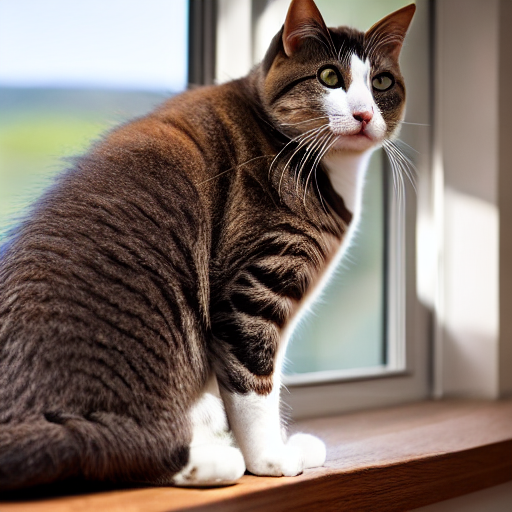


📝 ВАШ ЗАПРОС: кот сидит на подоконнике

✅ Изображение классифицировано как: cat
   Уверенность: 1.00

📋 Сгенерированный промпт: cat, sitting on windowsill, indoor, detailed fur, sunlight, cozy, domestic, realistic,
----------------------------------------

Введите русский запрос для генерации (или 'выход' для завершения):

----------------------------------------
⏳ Генерация изображения...

РЕЗУЛЬТАТ:

🖼️ Сгенерированное изображение:


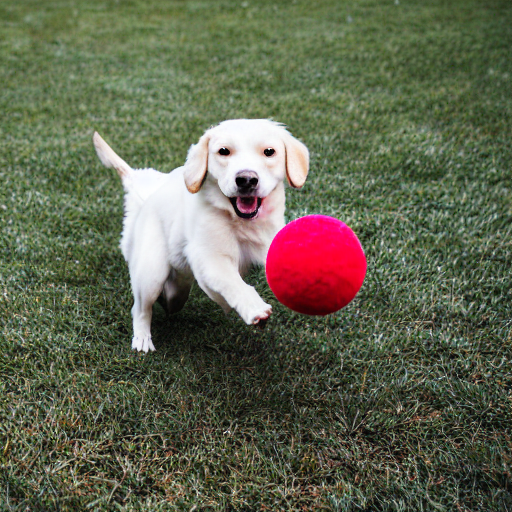


📝 ВАШ ЗАПРОС: собака играет с мячом

✅ Изображение классифицировано как: dog
   Уверенность: 0.95

📋 Сгенерированный промпт: dog, playing with ball, joyful, action shot, detailed fur, realistic, outdoor, playful,
----------------------------------------

Введите русский запрос для генерации (или 'выход' для завершения):

----------------------------------------
⏳ Генерация изображения...

РЕЗУЛЬТАТ:

🖼️ Сгенерированное изображение:


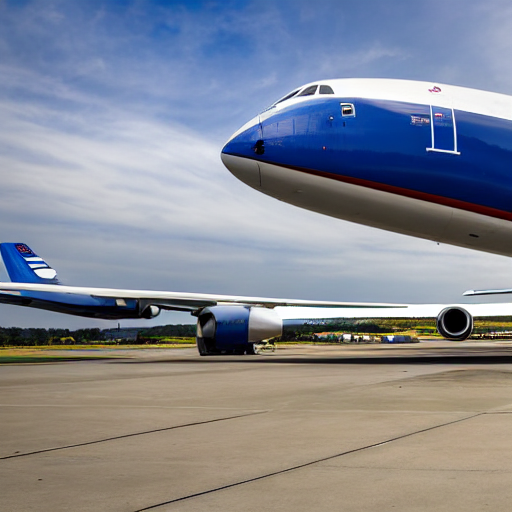


📝 ВАШ ЗАПРОС: самолет крупным планом летит

❌ К сожалению, ваша картинка не относится ни к одному из 8 классов
   (уверенность модели: 0.59)

📋 Сгенерированный промпт: cargo plane, flying with heavy load, detailed, realistic, aviation photography, sky, clouds, airport
----------------------------------------

Введите русский запрос для генерации (или 'выход' для завершения):

----------------------------------------
⏳ Генерация изображения...

РЕЗУЛЬТАТ:

🖼️ Сгенерированное изображение:


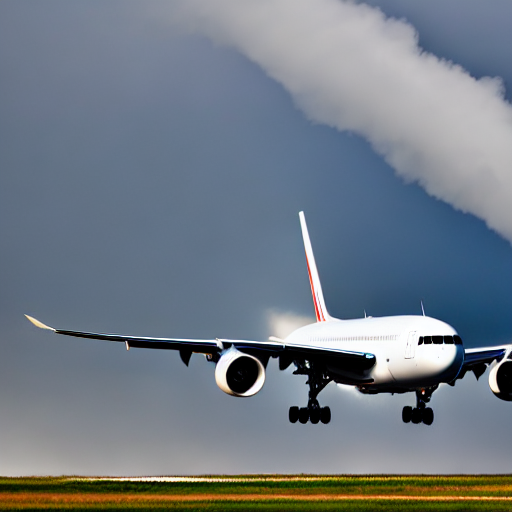


📝 ВАШ ЗАПРОС: самолет летит

✅ Изображение классифицировано как: flower
   Уверенность: 0.83

📋 Сгенерированный промпт: airplane, flying, sky, detailed, realistic, aviation photography, outdoor, clouds, motion blur
----------------------------------------

Введите русский запрос для генерации (или 'выход' для завершения):

----------------------------------------
⏳ Генерация изображения...

РЕЗУЛЬТАТ:

🖼️ Сгенерированное изображение:


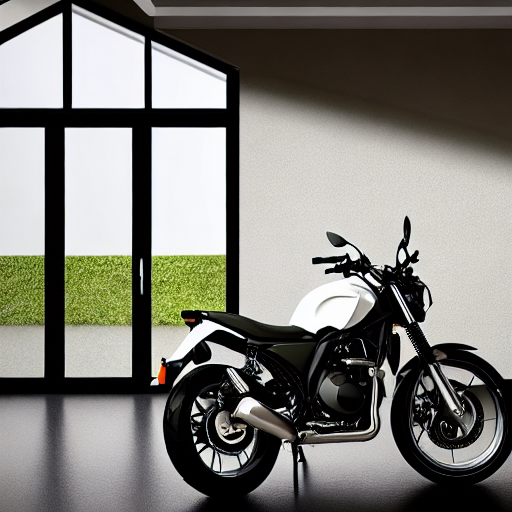


📝 ВАШ ЗАПРОС: мотоцикл стоит в гараже

✅ Изображение классифицировано как: motorbike
   Уверенность: 1.00

📋 Сгенерированный промпт: motorcycle, parked in garage, indoor, detailed, realistic, cozy, domestic, soft lighting,
----------------------------------------

Введите русский запрос для генерации (или 'выход' для завершения):

----------------------------------------
⏳ Генерация изображения...

РЕЗУЛЬТАТ:

🖼️ Сгенерированное изображение:


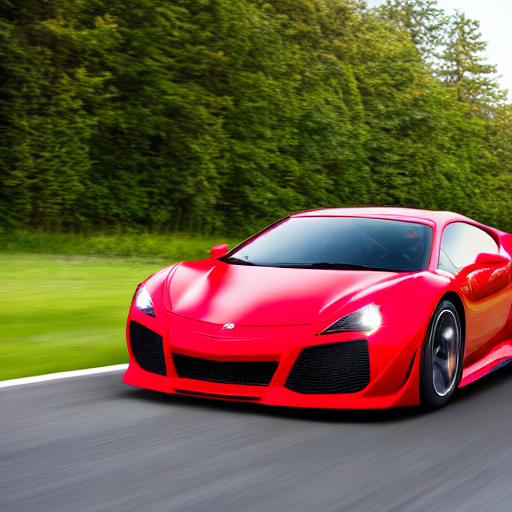


📝 ВАШ ЗАПРОС: красная спортивная машина

✅ Изображение классифицировано как: flower
   Уверенность: 1.00

📋 Сгенерированный промпт: red sports car, shiny, fast, detailed, outdoor, realistic, speed, motion blur, action
----------------------------------------

Введите русский запрос для генерации (или 'выход' для завершения):
Завершение работы...


In [24]:
def user_service(pipeline):
    """Интерактивный сервис для пользователя"""
    print("="*60)
    print("СЕРВИС ГЕНЕРАЦИИ И ВАЛИДАЦИИ ИЗОБРАЖЕНИЙ")
    print("="*60)
    
    while True:
        print("\nВведите русский запрос для генерации (или 'выход' для завершения):")
        user_input = input("> ").strip()
        
        if user_input.lower() in ['выход', 'exit', 'quit']:
            print("Завершение работы...")
            break
        
        if not user_input:
            print("Запрос не может быть пустым!")
            continue
        
        try:
            print("\n" + "-"*40)
            print("⏳ Генерация изображения...")
            
            result = pipeline.process_pipeline(
                russian_prompt=user_input,
                save_image=False  # Не сохраняем в файл, т.к. показываем сразу
            )
            
            # Интерпретация результата
            print("\n" + "="*40)
            print("РЕЗУЛЬТАТ:")
            print("="*40)
            
            # 1. Показываем изображение
            print("\n🖼️ Сгенерированное изображение:")
            display(result['image'])  # Показываем в ноутбуке

            # 2. Выводим исходный запрос пользователя (ДОБАВЬТЕ ЭТОТ БЛОК)
            print("\n" + "="*40)
            print(f"📝 ВАШ ЗАПРОС: {user_input}")
            print("="*40)
            
            # 3. Информация о классификации
            if result['confidence'] < 0.6:
                print("\n❌ К сожалению, ваша картинка не относится ни к одному из 8 классов")
                print(f"   (уверенность модели: {result['confidence']:.2f})")
            else:
                print(f"\n✅ Изображение классифицировано как: {result['predicted_class']}")
                print(f"   Уверенность: {result['confidence']:.2f}")
            
            print(f"\n📋 Сгенерированный промпт: {result['sd_prompt']}")
            print("-"*40)
            
        except Exception as e:
            print(f"❌ Ошибка при обработке: {e}")

# Запускаем сервис
user_service(pipeline)